In [1]:
!pip install ucimlrepo

## Gerekli Kütüphanelerin İçe Aktarılması ve Veri Setinin Yüklenmesi

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from itertools import cycle
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [3]:
from ucimlrepo import fetch_ucirepo

# Veri setini yükle
dry_bean = fetch_ucirepo(id=602)

# Özellikler ve hedef değişken
X = dry_bean.data.features
y = dry_bean.data.targets

df = pd.concat([X, y], axis=1)
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRatio      13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  Roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [5]:
X.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166


In [6]:
y.value_counts()

,count
Class,
DERMASON,3546
SIRA,2636
SEKER,2027
HOROZ,1928
CALI,1630
BARBUNYA,1322
BOMBAY,522


In [7]:
df.shape

(13611, 17)

## Eksik Veri Ekleme


In [8]:
# Rastgele sütunlara eksik veri ekle
def add_missing_data(df, columns, missing_rate):
  """
  Verilen sütunlara belirtilen oranda eksik veri ekler.

  Args:
    df: Pandas DataFrame.
    columns: Eksik veri eklenecek sütunların listesi.
    missing_rate: Eksik veri oranı (0 ile 1 arasında).
  """
  for col in columns:
    df.loc[df.sample(frac=missing_rate).index, col] = np.nan
  return df

# Rastgele sütunları seç
columns_5_percent = np.random.choice(df.columns[:-1], size=2, replace=False)
column_35_percent = np.random.choice(df.columns[:-1], size=1, replace=False)[0]

# Eksik verileri ekle
df = add_missing_data(df, columns_5_percent, 0.05)
df = add_missing_data(df, [column_35_percent], 0.35)

# Eksik verileri gözlemle
print(df.isnull().sum())

Area                  0
Perimeter             0
MajorAxisLength    4764
MinorAxisLength       0
AspectRatio           0
Eccentricity          0
ConvexArea            0
EquivDiameter         0
Extent              681
Solidity              0
Roundness           681
Compactness           0
ShapeFactor1          0
ShapeFactor2          0
ShapeFactor3          0
ShapeFactor4          0
Class                 0
dtype: int64


## Eksik Verilerin İşlenmesi


In [9]:
# Eksik verileri doldurma/silme
def handle_missing_data(df, columns_5_percent, column_35_percent):
  """
  Eksik verileri belirtilen yöntemlerle doldurur veya siler.

  Args:
    df: Pandas DataFrame.
    columns_5_percent: %5 eksik veri içeren sütunların listesi.
    column_35_percent: %35 eksik veri içeren sütun.

  Returns:
    Pandas DataFrame (eksik verilerle işlem görmüş).
  """

  # %5 eksik verileri ortalama ile doldur
  for col in columns_5_percent:
    df[col].fillna(df[col].mean(), inplace=True)

  # %35 eksik verileri içeren satırları sil
  df.dropna(subset=[column_35_percent], inplace=True)

  return df

# Fonksiyonu çağır
df = handle_missing_data(df, columns_5_percent, column_35_percent)

# Eksik verileri tekrar kontrol et
print(df.isnull().sum())

Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRatio        0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
Roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64


<ipython-input-9-f635109a5393>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


## Aykırı Değer Tespiti ve İşlenmesi (IQR Yöntemi)


In [10]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
numerical_cols

['Area',
 'Perimeter',
 'MajorAxisLength',
 'MinorAxisLength',
 'AspectRatio',
 'Eccentricity',
 'ConvexArea',
 'EquivDiameter',
 'Extent',
 'Solidity',
 'Roundness',
 'Compactness',
 'ShapeFactor1',
 'ShapeFactor2',
 'ShapeFactor3',
 'ShapeFactor4']

In [11]:
# Aykırı değer tespiti ve işleme
def handle_outliers_iqr(df, columns):
    """
    Belirtilen sütunlardaki aykırı değerleri IQR yöntemiyle tespit eder ve sınır değerlerle değiştirir.

    Args:
        df: Pandas DataFrame.
        columns: Aykırı değer tespiti yapılacak sütunların listesi.

    Returns:
        Pandas DataFrame (aykırı değerlerle işlem görmüş).
    """
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Aykırı değerleri sınır değerlerle değiştir
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# Aykırı değerleri işle
df = handle_outliers_iqr(df, numerical_cols)
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
2,29380.0,624.110,212.826130,175.931143,1.209713,0.569684,29690.0,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008.0,645.884,210.557999,182.516516,1.153638,0.569684,30724.0,195.467062,0.782681,0.979178,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140.0,620.134,201.847882,190.279279,1.060798,0.569684,30417.0,195.896503,0.773098,0.990893,0.984877,0.944102,0.006697,0.003665,0.871535,0.999166,SEKER
8,30685.0,635.681,213.534145,183.157146,1.165852,0.569684,31044.0,197.659696,0.771561,0.988436,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,SEKER
10,30917.0,640.765,213.560089,184.439871,1.157885,0.569684,31280.0,198.405511,0.770805,0.988395,0.946258,0.929038,0.006908,0.003174,0.863112,0.999384,SEKER


## Özellik Ölçekleme


In [12]:
# Özellik ölçekleme (StandardScaler)
def scale_features(df, columns):
    """
    Belirtilen sütunları StandardScaler ile ölçekler.

    Args:
        df: Pandas DataFrame.
        columns: Ölçeklenecek sütunların listesi.

    Returns:
        Pandas DataFrame (ölçeklenmiş sütunlarla).
    """
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

# Ölçekleme yapılacak sütunları belirle (sayısal sütunlar)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Özellikleri ölçekle
df = scale_features(df, numerical_cols)
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
2,-1.110135,-1.186823,-1.324855,-0.698539,-1.534881,-2.18896,-1.108349,-1.190368,0.600885,0.589333,1.297308,1.765987,0.621134,2.237138,1.852897,1.123252,SEKER
3,-1.076538,-1.070973,-1.353411,-0.495731,-1.767583,-2.18896,-1.054145,-1.146646,0.699151,-2.293704,0.530569,2.083992,0.409797,2.518023,2.218699,-0.355871,SEKER
4,-1.069476,-1.207978,-1.463073,-0.256663,-2.152858,-2.18896,-1.070238,-1.137514,0.493000,0.959960,1.943823,2.340506,0.112380,3.276364,2.317880,1.153617,SEKER
8,-1.040320,-1.125259,-1.315941,-0.476001,-1.716897,-2.18896,-1.037370,-1.100021,0.459946,0.277439,1.408885,2.040566,0.356011,2.411931,2.168287,1.088865,SEKER
10,-1.027908,-1.098209,-1.315615,-0.436498,-1.749961,-2.18896,-1.024999,-1.084162,0.443679,0.266156,1.269523,2.095530,0.308214,2.450100,2.232118,1.219966,SEKER


## Kategorik Verilerin Kodlanması


In [13]:
# Kategorik verilerin kodlanması
def encode_categorical_labels(df, target_column):
    """
    Hedef sütunundaki kategorik etiketleri LabelEncoder ile sayısal değerlere dönüştürür.

    Args:
        df: Pandas DataFrame.
        target_column: Kodlanacak hedef sütunun adı.

    Returns:
        Pandas DataFrame (kodlanmış hedef sütunuyla).
    """
    encoder = LabelEncoder()
    df[target_column] = encoder.fit_transform(df[target_column])
    return df, encoder

# Hedef değişkeni kodla
df, label_encoder = encode_categorical_labels(df, 'Class')
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRatio,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
2,-1.110135,-1.186823,-1.324855,-0.698539,-1.534881,-2.18896,-1.108349,-1.190368,0.600885,0.589333,1.297308,1.765987,0.621134,2.237138,1.852897,1.123252,5
3,-1.076538,-1.070973,-1.353411,-0.495731,-1.767583,-2.18896,-1.054145,-1.146646,0.699151,-2.293704,0.530569,2.083992,0.409797,2.518023,2.218699,-0.355871,5
4,-1.069476,-1.207978,-1.463073,-0.256663,-2.152858,-2.18896,-1.070238,-1.137514,0.493000,0.959960,1.943823,2.340506,0.112380,3.276364,2.317880,1.153617,5
8,-1.040320,-1.125259,-1.315941,-0.476001,-1.716897,-2.18896,-1.037370,-1.100021,0.459946,0.277439,1.408885,2.040566,0.356011,2.411931,2.168287,1.088865,5
10,-1.027908,-1.098209,-1.315615,-0.436498,-1.749961,-2.18896,-1.024999,-1.084162,0.443679,0.266156,1.269523,2.095530,0.308214,2.450100,2.232118,1.219966,5


# Bölüm 2: Özellik Seçimi ve Boyut İndirgeme

In [14]:
# 1. Ham veri
df_ham = df.copy()
X_ham = df_ham.drop('Class', axis=1)
y_ham = df_ham['Class']

# 2. PCA ile dönüştürülmüş veri
def apply_pca(X, n_components=None):
    """
    PCA uygular ve dönüştürülmüş veriyi döndürür.

    Args:
        X: Özellik matrisi.
        n_components: Seçilecek bileşen sayısı (None ise otomatik seçim yapılır).

    Returns:
        Dönüştürülmüş özellik matrisi ve PCA nesnesi.
    """
    # Eğer n_components belirtilmemişse, varyans oranlarına göre otomatik seç
    if n_components is None:
        pca = PCA()
        pca.fit(X)
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance_ratio)
        n_components = np.argmax(cumulative_variance >= np.mean(explained_variance_ratio)) + 1  # ortalamadan büyük ilk değer

        if n_components < 2:
            print("Uyarı: PCA sadece 1 bileşen üretti. Görselleştirme yapılamaz.")
            return None, None  # Görselleştirme yapılamayacağı için None döndür

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca, pca

X_pca, pca_model = apply_pca(X_ham, n_components=2)

# 3. LDA ile dönüştürülmüş veri
def apply_lda(X, y, n_components=3):
    """
    LDA uygular ve dönüştürülmüş veriyi döndürür.

    Args:
        X: Özellik matrisi.
        y: Hedef değişken.
        n_components: Bileşen sayısı (varsayılan: 3).

    Returns:
        Dönüştürülmüş özellik matrisi ve LDA nesnesi.
    """
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_lda = lda.fit_transform(X, y)
    return X_lda, lda

X_lda, lda_model = apply_lda(X_ham, y_ham)

print("Ham Veri Boyutu:", X_ham.shape)

# PCA'nın başarılı olup olmadığını kontrol et
if X_pca is not None:
    print("PCA ile Dönüştürülmüş Veri Boyutu:", X_pca.shape)
else:
    print("PCA ile dönüştürme başarısız oldu.")

print("LDA ile Dönüştürülmüş Veri Boyutu:", X_lda.shape)

Ham Veri Boyutu: (8847, 16)
PCA ile Dönüştürülmüş Veri Boyutu: (8847, 2)
LDA ile Dönüştürülmüş Veri Boyutu: (8847, 3)


PCA Sonuçlarının Görselleştirilmesi

<ipython-input-16-3f7730afc943>:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.viridis(i/len(classes)), label=class_name)


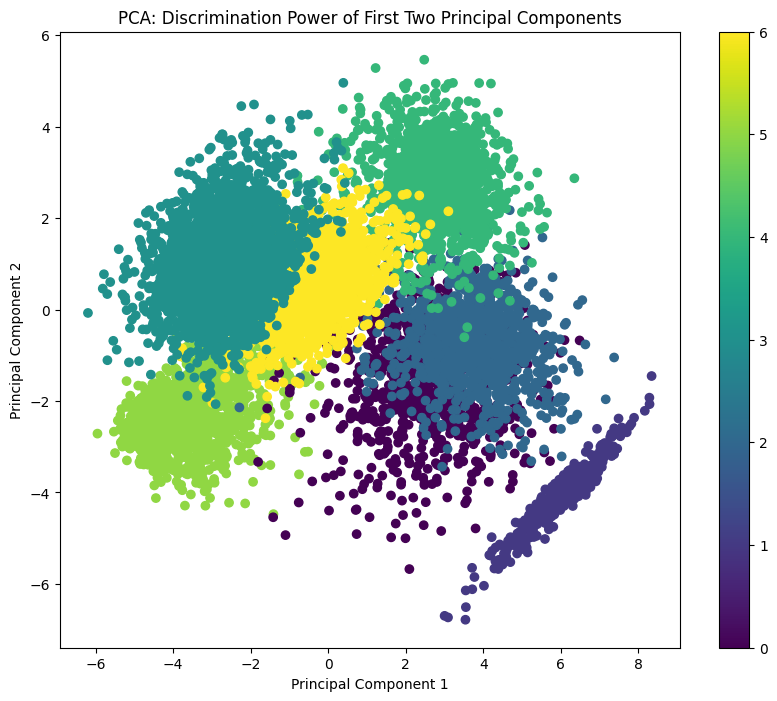

In [16]:
def visualize_pca(X_pca, y, pca_model, label_encoder):
    """
    PCA sonuçlarını 2 boyutlu olarak görselleştirir.

    Args:
        X_pca: PCA ile dönüştürülmüş veri.
        y: Hedef değişken.
        pca_model: Eğitilmiş PCA modeli.
        label_encoder: LabelEncoder nesnesi.
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')

    # Sınıf etiketlerini al
    classes = label_encoder.classes_

    for i, class_name in enumerate(classes):
        plt.scatter([], [], c=plt.cm.viridis(i/len(classes)), label=class_name)

    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA: Discrimination Power of First Two Principal Components")
    plt.colorbar(scatter)
    plt.show()

# Görselleştirme fonksiyonunu çağır
visualize_pca(X_pca, y_ham, pca_model, label_encoder)

#### PCA Grafiğin Genel Anlamı

Bu grafik, Dry Bean veri setindeki verilerin, PCA uygulandıktan sonraki ilk iki temel bileşen (Principal Component) uzayındaki dağılımını göstermektedir. Her bir nokta bir kuru fasulye örneğini temsil eder ve noktaların rengi fasulye türünü belirtir. Amaç, PCA'nın boyut indirgeme işleminden sonra, ilk iki bileşenin farklı fasulye türlerini ne kadar iyi ayırabildiğini görsel olarak değerlendirmektir.

Eksenler:
  - Principal Component 1 (PC1): Yatay eksen, ilk temel bileşeni temsil eder. Bu bileşen, verideki varyansın en büyük kısmını açıklar.
  - Principal Component 2 (PC2): Dikey eksen, ikinci temel bileşeni temsil eder. Bu bileşen, PC1'e diktir ve verideki varyansın ikinci en büyük kısmını açıklar.

Renkler:
Her bir renk, farklı bir kuru fasulye türünü temsil eder. Renklerin dağılımı, farklı türlerin PC1 ve PC2 uzayında nasıl kümelendiğini veya yayıldığını gösterir.

Yorum:

1. Kümelenme (Clustering): Bazı renklerin (yani, bazı fasulye türlerinin) belirli bölgelerde yoğunlaştığı görülmektedir. Bu, PCA'nın bu türleri diğerlerinden ayırmada başarılı olduğunu gösterir. Örneğin, grafiğin sol alt köşesindeki sarı-yeşil küme ve sağ alt köşesindeki mor küme oldukça belirgin bir şekilde ayrılmıştır.

2. Örtüşme (Overlap): Bazı renklerin ise birbirleriyle örtüştüğü görülmektedir. Bu, PCA'nın bu türleri birbirinden ayırmada zorlandığını gösterir. Özellikle grafiğin merkezindeki bölgelerde, farklı renklerin karıştığı görülmektedir. Bu, bu türler arasındaki özelliklerin daha benzer olduğunu veya PCA'nın bu özellikleri yeterince ayırt edemediğini gösterir.

3. Varyans Açıklama: PC1 ve PC2'nin toplamda verideki varyansın ne kadarını açıkladığı da önemlidir. Eğer bu oran düşükse, ilk iki bileşenin veriyi yeterince temsil etmediği ve dolayısıyla ayrımın zayıf olduğu düşünülebilir. (Bu bilgi grafikte doğrudan yer almasa da, PCA uygularken hesaplanmıştır.)

4. Ayrik Alanlar: Grafikte belirgin bir sekilde ayrik bir mor küme bulunuyor. Bu küme, mor renkle temsil edilen fasulye türünün, diğer türlerden belirgin şekilde farklı özelliklere sahip olduğunu ve bu nedenle PCA uzayında kolayca ayrılabildiğini gösterir.

LDA Sonuçlarının Görselleştirilmesi

<ipython-input-18-bcde8d099576>:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.viridis(i/len(classes)), label=class_name)


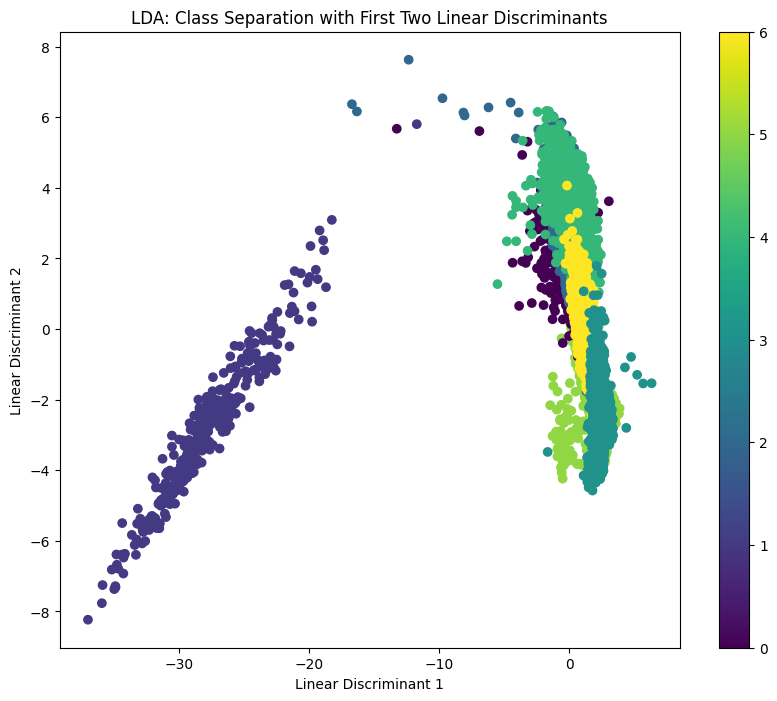

In [18]:
def visualize_lda(X_lda, y, lda_model, label_encoder):
    """
    LDA sonuçlarını 2 boyutlu olarak görselleştirir.

    Args:
        X_lda: LDA ile dönüştürülmüş veri.
        y: Hedef değişken.
        lda_model: Eğitilmiş LDA modeli.
        label_encoder: LabelEncoder nesnesi.
    """
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='viridis')

    # Sınıf etiketlerini al
    classes = label_encoder.classes_

    for i, class_name in enumerate(classes):
        plt.scatter([], [], c=plt.cm.viridis(i/len(classes)), label=class_name)

    plt.xlabel("Linear Discriminant 1")
    plt.ylabel("Linear Discriminant 2")
    plt.title("LDA: Class Separation with First Two Linear Discriminants")
    plt.colorbar(scatter)
    plt.show()

# Görselleştirme fonksiyonunu çağır
visualize_lda(X_lda, y_ham, lda_model, label_encoder)

#### LDA Grafiğin Genel Anlamı
Bu grafik, Dry Bean veri setindeki verilerin, LDA (Linear Discriminant Analysis) uygulandıktan sonraki ilk iki doğrusal discriminant (Linear Discriminant) uzayındaki dağılımını göstermektedir. Her bir nokta bir kuru fasulye örneğini temsil eder ve noktaların rengi fasulye türünü belirtir. Amaç, LDA'nın boyut indirgeme işleminden sonra, ilk iki discriminant'ın farklı fasulye türlerini ne kadar iyi ayırabildiğini görsel olarak değerlendirmektir. LDA, PCA'dan farklı olarak, sınıflar arası ayrımı maksimize etmeyi hedefler.

Eksenler:
  - Linear Discriminant 1 (LD1): Yatay eksen, ilk doğrusal discriminant'ı temsil eder. Bu discriminant, sınıflar arasındaki ayrımın en büyük kısmını açıklar.
  - Linear Discriminant 2 (LD2): Dikey eksen, ikinci doğrusal discriminant'ı temsil eder. Bu discriminant, LD1'e diktir ve sınıflar arasındaki ayrımın ikinci en büyük kısmını açıklar.

Renkler:

Her bir renk, farklı bir kuru fasulye türünü temsil eder. Renklerin dağılımı, farklı türlerin LD1 ve LD2 uzayında nasıl kümelendiğini veya yayıldığını gösterir.

Yorum:

1. Ayrımın Belirginliği: Grafikte, PCA grafiğine kıyasla sınıflar arasında daha belirgin bir ayrım olduğu görülmektedir. Özellikle, sağ taraftaki dikey eksen boyunca farklı renklerin sıralandığı bir yapı oluşmuştur. Bu, LDA'nın sınıflar arası ayrımı maksimize etme hedefinde başarılı olduğunu gösterir.

2. Kümelenme (Clustering): Bazı renklerin (yani, bazı fasulye türlerinin) belirli bölgelerde yoğunlaştığı görülmektedir. Bu, LDA'nın bu türleri diğerlerinden ayırmada başarılı olduğunu gösterir.

3. Doğrusal Yapı: Verilerin doğrusal discriminant'lar boyunca sıralanmış olması, LDA'nın doğrusal bir dönüşüm uyguladığını ve sınıflar arasındaki ayrımı doğrusal bir şekilde ifade ettiğini gösterir.

4. Ayrik grup: Sol tarafta belirgin bir sekilde ayrik bir mor küme bulunuyor. Bu küme, mor renkle temsil edilen fasulye türünün, diğer türlerden belirgin şekilde farklı özelliklere sahip olduğunu ve bu nedenle LDA uzayında kolayca ayrılabildiğini gösterir.

5. Örtüşme: Grafik genel olarak daha iyi bir ayırım gösterse de, sağ taraftaki bazı renkler (özellikle ortadaki dikey eksen boyunca) hala birbirleriyle örtüşmektedir. Bu, LDA'nın bile bazı türler arasındaki ayrımı tam olarak sağlayamadığını gösterir.

# Bölüm 3: Modelleme ve Değerlendirme


nested cross-validation kullanarak farklı sınıflandırma algoritmalarını değerlendirme

In [22]:
def nested_cross_validation(X, y, model, param_grid, outer_cv, inner_cv):
    """
    Nested cross-validation uygular.

    Args:
        X: Özellik matrisi.
        y: Hedef değişken.
        model: Sınıflandırma modeli.
        param_grid: Hiperparametre aralığı.
        outer_cv: Dış döngüdeki katman sayısı.
        inner_cv: İç döngüdeki katman sayısı.

    Returns:
        Performans metriklerinin ortalaması ve standart sapması.
    """
    outer_scores = []
    skf_outer = StratifiedKFold(n_splits=outer_cv, shuffle=True, random_state=42)

    for train_index, test_index in skf_outer.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        skf_inner = StratifiedKFold(n_splits=inner_cv, shuffle=True, random_state=42)
        grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=skf_inner, refit=True)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        outer_scores.append([accuracy, precision, recall, f1])

    outer_scores = np.array(outer_scores)
    mean_scores = np.mean(outer_scores, axis=0)
    std_scores = np.std(outer_scores, axis=0)

    return mean_scores, std_scores

## Modelleri Uygulama ve Değerlendirme

In [20]:
# Modelleri tanımla ve hiperparametre aralıklarını belirle
models = {
    'Logistic Regression': (LogisticRegression(random_state=42), {'C': [0.1, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {'max_depth': [5, 10, 15]}),
    'Random Forest': (RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200]}),
    'XGBoost': (xgb.XGBClassifier(random_state=42), {'n_estimators': [50, 100, 200]}),
    'Naive Bayes': (GaussianNB(), {})
}

# Veri temsillerini tanımla
data = {
    'Ham Veri': (X_ham.values, y_ham.values),
    'PCA ile Dönüştürülmüş Veri': (X_pca, y_ham.values),
    'LDA ile Dönüştürülmüş Veri': (X_lda, y_ham.values)
}

# Nested cross-validation uygula ve sonuçları sakla
results = {}

for data_name, (X, y) in data.items():
    results[data_name] = {}
    for model_name, (model, param_grid) in models.items():
        print(f"Veri: {data_name}, Model: {model_name}")
        mean_scores, std_scores = nested_cross_validation(X, y, model, param_grid, 5, 3)
        results[data_name][model_name] = (mean_scores, std_scores)

        print(f"  Accuracy: {mean_scores[0]:.4f} (+/- {std_scores[0]:.4f})")
        print(f"  Precision: {mean_scores[1]:.4f} (+/- {std_scores[1]:.4f})")
        print(f"  Recall: {mean_scores[2]:.4f} (+/- {std_scores[2]:.4f})")
        print(f"  F1 Score: {mean_scores[3]:.4f} (+/- {std_scores[3]:.4f})\n")

Veri: Ham Veri, Model: Logistic Regression
  Accuracy: 0.9219 (+/- 0.0078)
  Precision: 0.9224 (+/- 0.0073)
  Recall: 0.9219 (+/- 0.0078)
  F1 Score: 0.9220 (+/- 0.0076)
Veri: Ham Veri, Model: Decision Tree
  Accuracy: 0.8992 (+/- 0.0063)
  Precision: 0.8999 (+/- 0.0060)
  Recall: 0.8992 (+/- 0.0063)
  F1 Score: 0.8993 (+/- 0.0061)
Veri: Ham Veri, Model: Random Forest
  Accuracy: 0.9184 (+/- 0.0057)
  Precision: 0.9186 (+/- 0.0053)
  Recall: 0.9184 (+/- 0.0057)
  F1 Score: 0.9183 (+/- 0.0056)
Veri: Ham Veri, Model: XGBoost
  Accuracy: 0.9213 (+/- 0.0060)
  Precision: 0.9216 (+/- 0.0060)
  Recall: 0.9213 (+/- 0.0060)
  F1 Score: 0.9213 (+/- 0.0060)
Veri: Ham Veri, Model: Naive Bayes
  Accuracy: 0.8963 (+/- 0.0069)
  Precision: 0.8979 (+/- 0.0062)
  Recall: 0.8963 (+/- 0.0069)
  F1 Score: 0.8965 (+/- 0.0068)
Veri: PCA ile Dönüştürülmüş Veri, Model: Logistic Regression
  Accuracy: 0.8700 (+/- 0.0091)
  Precision: 0.8697 (+/- 0.0089)
  Recall: 0.8700 (+/- 0.0091)
  F1 Score: 0.8691 (+/- 0.

---

| Veri Temsili                  | Model                  | Accuracy | Precision | Recall | F1 Score |
| ----------------------------- | ---------------------- | -------- | --------- | ------ | -------- |
| **Ham Veri**                  | Logistic Regression    | 0.9219   | 0.9224    | 0.9219 | 0.9220   |
| **Ham Veri**                  | Decision Tree          | 0.8992   | 0.8999    | 0.8992 | 0.8993   |
| **Ham Veri**                  | Random Forest          | 0.9184   | 0.9186    | 0.9184 | 0.9183   |
| **Ham Veri**                  | XGBoost                | 0.9213   | 0.9216    | 0.9213 | 0.9213   |
| **Ham Veri**                  | Naive Bayes            | 0.8963   | 0.8979    | 0.8963 | 0.8965   |
| **PCA ile Dönüştürülmüş Veri** | Logistic Regression    | 0.8700   | 0.8697    | 0.8700 | 0.8691   |
| **PCA ile Dönüştürülmüş Veri** | Decision Tree          | 0.8464   | 0.8482    | 0.8464 | 0.8467   |
| **PCA ile Dönüştürülmüş Veri** | Random Forest          | 0.8572   | 0.8564    | 0.8572 | 0.8564   |
| **PCA ile Dönüştürülmüş Veri** | XGBoost                | 0.8609   | 0.8601    | 0.8609 | 0.8597   |
| **PCA ile Dönüştürülmüş Veri** | Naive Bayes            | 0.8611   | 0.8615    | 0.8611 | 0.8583   |
| **LDA ile Dönüştürülmüş Veri** | Logistic Regression    | 0.8196   | 0.8191    | 0.8196 | 0.8177   |
| **LDA ile Dönüştürülmüş Veri** | Decision Tree          | 0.8411   | 0.8419    | 0.8411 | 0.8411   |
| **LDA ile Dönüştürülmüş Veri** | Random Forest          | 0.8611   | 0.8619    | 0.8611 | 0.8611   |
| **LDA ile Dönüştürülmüş Veri** | XGBoost                | 0.8593   | 0.8600    | 0.8593 | 0.8593   |
| **LDA ile Dönüştürülmüş Veri** | Naive Bayes            | 0.7941   | 0.7923    | 0.7941 | 0.7815   |

---

#### Tablonun Genel Anlamı:

Bu tablo, farklı makine öğrenmesi modellerinin ve farklı veri temsillerinin, kuru fasulye sınıflandırma problemindeki performansını özetlemektedir. Modellerin performansı, Accuracy (doğruluk), Precision (kesinlik), Recall (duyarlılık) ve F1 Score (F1 skoru) gibi metriklerle ölçülmüştür. Veri temsilleri ise ham veri, PCA ile dönüştürülmüş veri ve LDA ile dönüştürülmüş veri olmak üzere üç farklıdır.

Teknik Yorum:

1. Ham Veri Üstünlüğü: En yüksek performans, genellikle ham veri ile elde edilmiştir. Bu, veri setindeki orijinal özelliklerin, fasulye türlerini sınıflandırmak için önemli bilgiler içerdiğini ve boyut indirgeme tekniklerinin (PCA ve LDA) bu bilgiyi kaybettiğini göstermektedir. Boyut indirgeme, özellikle gürültülü verilerde veya yüksek boyutlu uzaylarda faydalı olabilirken, bu veri setinde orijinal özellikler zaten iyi bir ayrım sağlamaktadır.

2. Logistic Regression ve XGBoost: Logistic Regression ve XGBoost modelleri, ham veri ile kullanıldığında en iyi sonuçları vermiştir. Logistic Regression, basit ve yorumlanabilir bir modeldir, bu da veri setindeki ilişkilerin nispeten doğrusal olduğunu düşündürmektedir. XGBoost ise daha karmaşık ilişkileri modelleme yeteneğine sahiptir ve bu veri setinde Logistic Regression'a yakın bir performans sergilemiştir.

3. Model Performansları:

  - Accuracy (Doğruluk): Modelin genel olarak ne kadar doğru tahmin yaptığıdır. En yüksek doğruluk değerleri, ham veri ile Logistic Regression ve XGBoost modellerinde elde edilmiştir (yaklaşık %92).

  - Precision (Kesinlik): Modelin pozitif olarak tahmin ettiği örneklerin ne kadarının gerçekten pozitif olduğudur. Yüksek precision, modelin yanlış pozitif tahminler yapma olasılığının düşük olduğunu gösterir.

  - Recall (Duyarlılık): Gerçekte pozitif olan örneklerin ne kadarının model tarafından doğru bir şekilde tahmin edildiğidir. Yüksek recall, modelin yanlış negatif tahminler yapma olasılığının düşük olduğunu gösterir.

  - F1 Score (F1 Skoru): Precision ve recall'un harmonik ortalamasıdır. Hem precision hem de recall'u dikkate alarak modelin genel performansını özetler. En yüksek F1 skorları, ham veri ile Logistic Regression ve XGBoost modellerinde elde edilmiştir (yaklaşık 0.9220 ve 0.9213).

4. Boyut İndirgeme Etkisi: PCA ve LDA ile dönüştürülmüş verilerle elde edilen sonuçlar, ham verilere göre daha düşüktür. Bu, boyut indirgeme tekniklerinin veri setindeki önemli bilgileri kaybettiğini ve sınıflandırma performansını olumsuz etkilediğini gösterir. Özellikle LDA ile elde edilen sonuçlar, PCA'ya göre daha düşüktür.

5. Naive Bayes Performansı: Naive Bayes modeli, diğer modellere göre daha düşük bir performans sergilemiştir. Naive Bayes, özellikler arasındaki bağımsızlık varsayımını yapar ve bu varsayım gerçek dünyadaki veri setlerinde genellikle geçerli değildir.

Sonuç:

Bu tablo, kuru fasulye sınıflandırma problemi için en etkili yaklaşımın, ham veri ile Logistic Regression veya XGBoost modellerini kullanmak olduğunu göstermektedir. Boyut indirgeme teknikleri (PCA ve LDA) bu veri setinde performansı iyileştirmemiş, aksine düşürmüştür. Bu, orijinal özelliklerin sınıflandırma için yeterli bilgi içerdiğini ve daha karmaşık modellere veya özellik mühendisliği tekniklerine ihtiyaç duyulmadığını düşündürmektedir.

## ROC Eğrileri Çizme ve Değerlendirme

ROC Curve: Veri: Ham Veri, Model: Logistic Regression


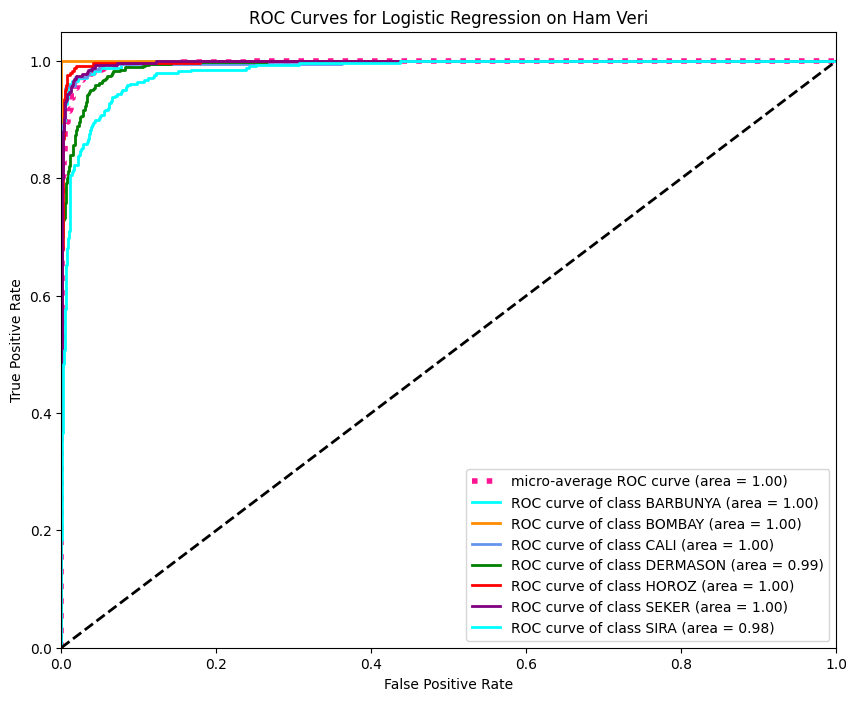

ROC Curve: Veri: Ham Veri, Model: Decision Tree


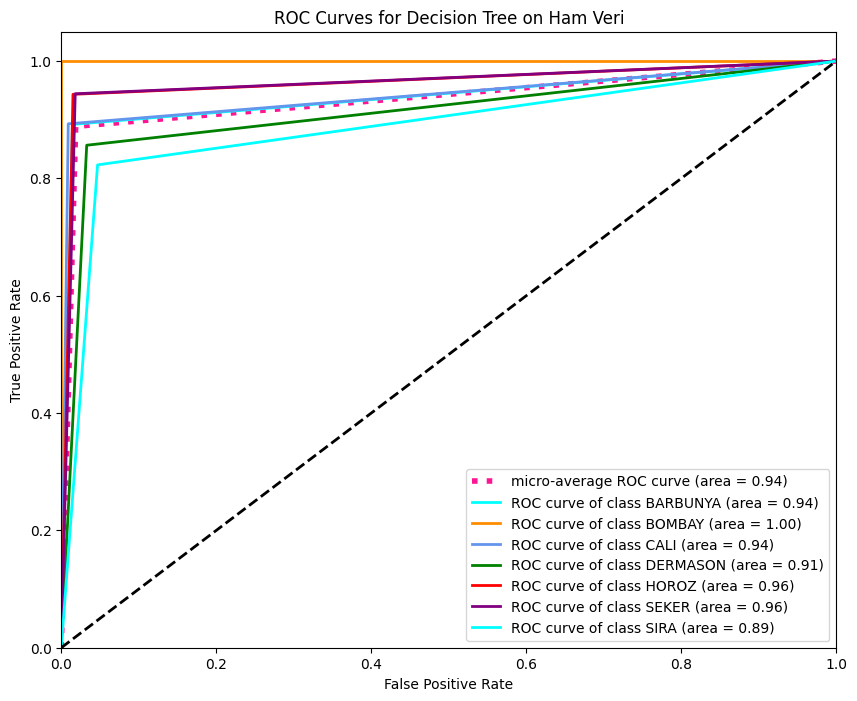

ROC Curve: Veri: Ham Veri, Model: Random Forest


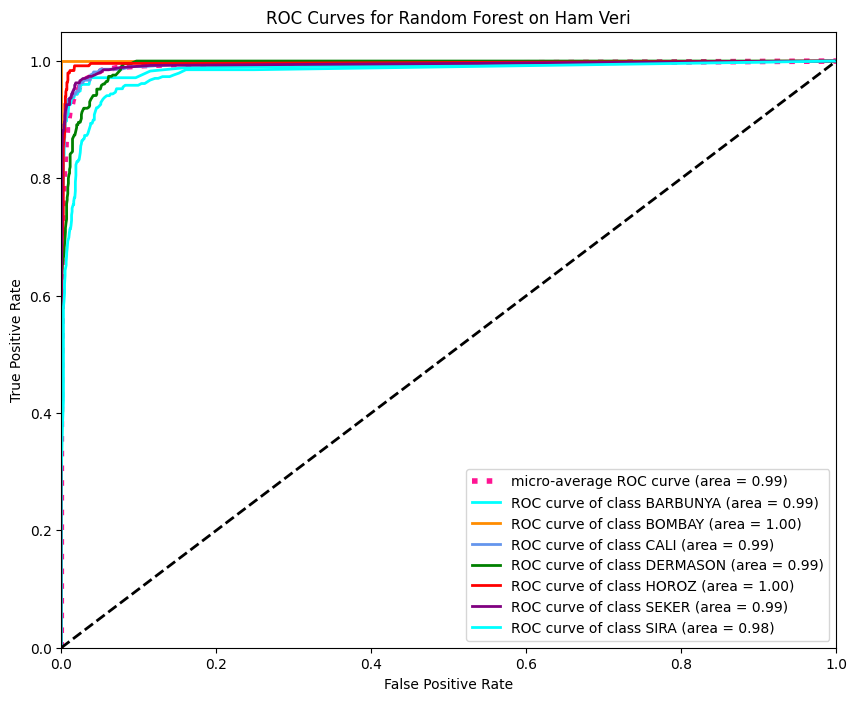

ROC Curve: Veri: Ham Veri, Model: XGBoost


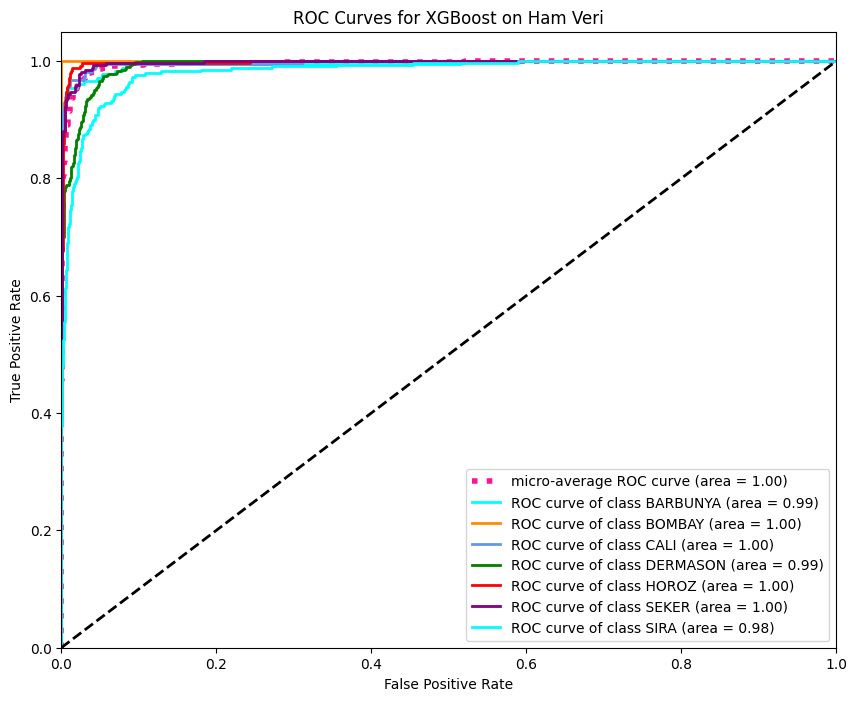

ROC Curve: Veri: Ham Veri, Model: Naive Bayes


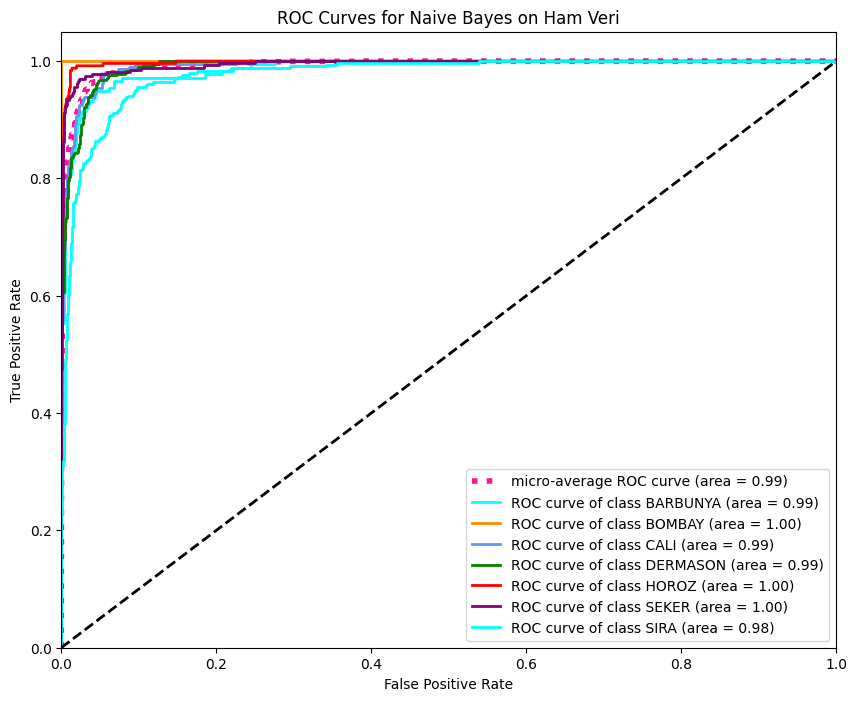

ROC Curve: Veri: PCA ile Dönüştürülmüş Veri, Model: Logistic Regression


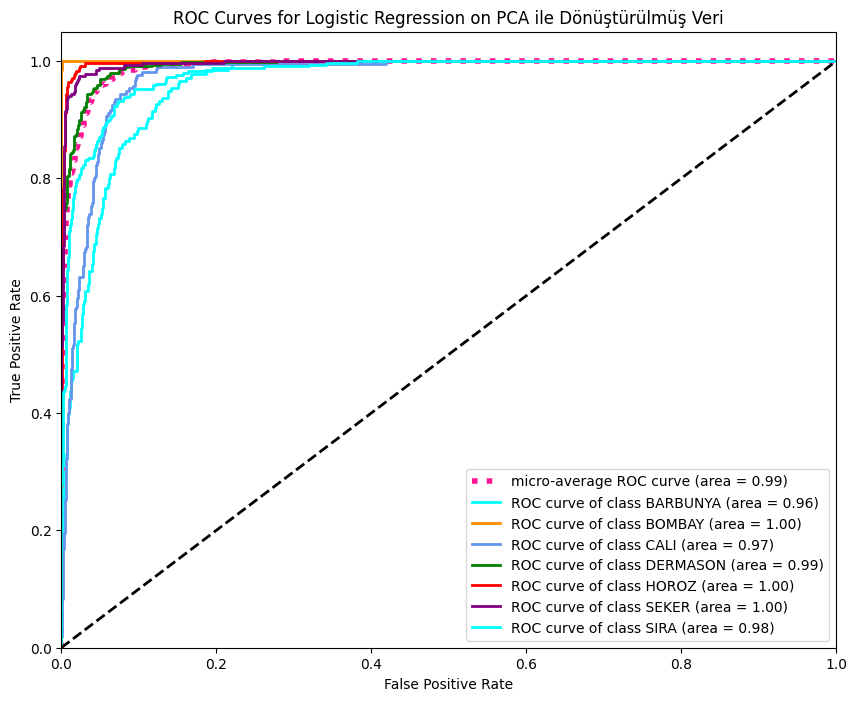

ROC Curve: Veri: PCA ile Dönüştürülmüş Veri, Model: Decision Tree


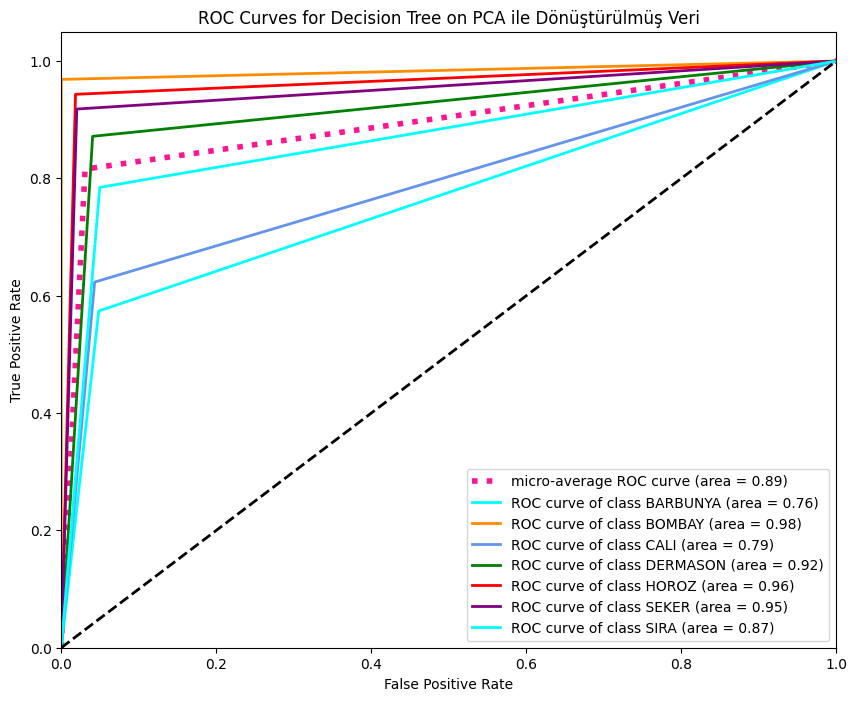

ROC Curve: Veri: PCA ile Dönüştürülmüş Veri, Model: Random Forest


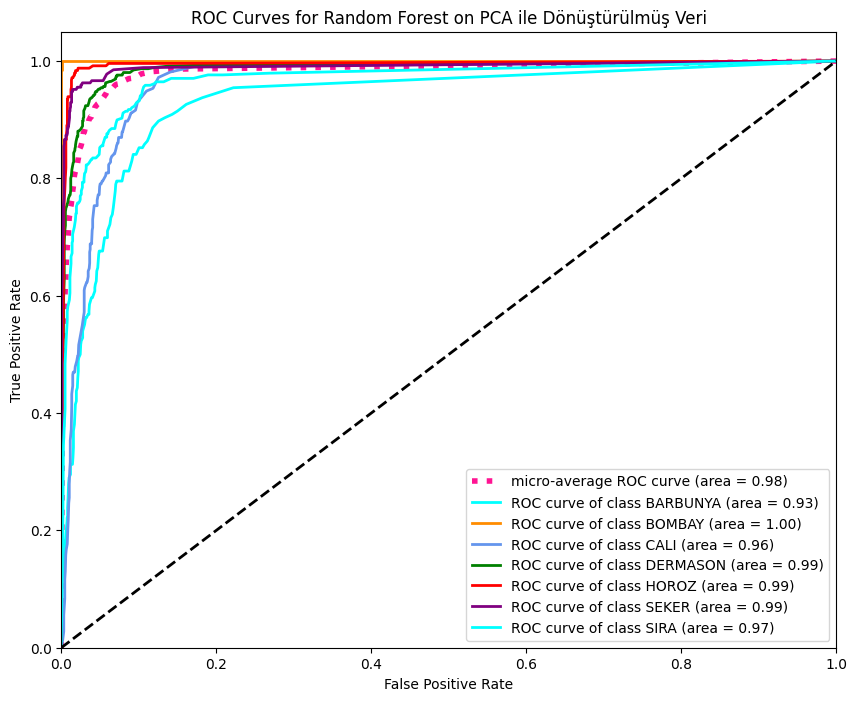

ROC Curve: Veri: PCA ile Dönüştürülmüş Veri, Model: XGBoost


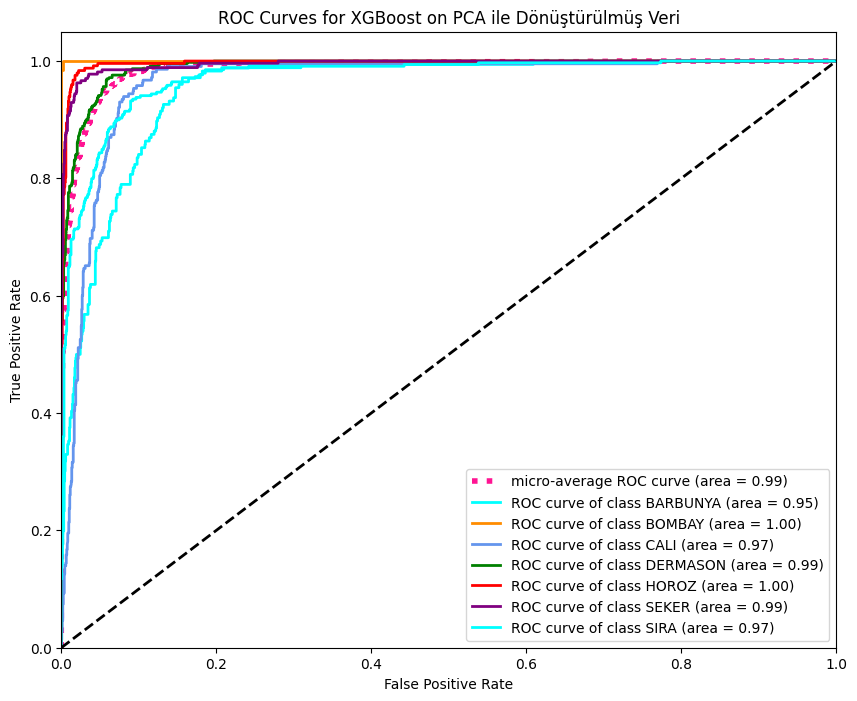

ROC Curve: Veri: PCA ile Dönüştürülmüş Veri, Model: Naive Bayes


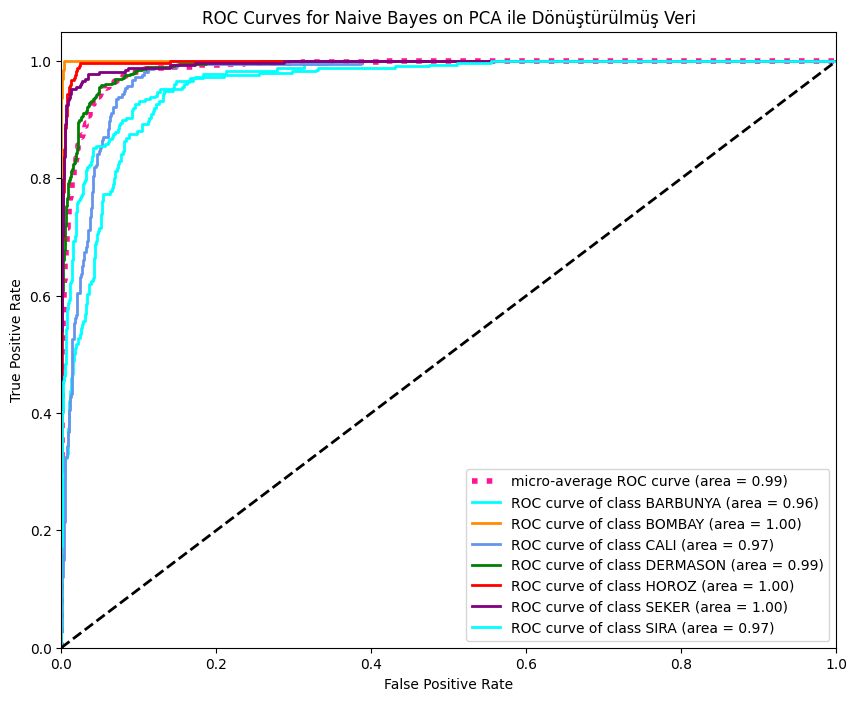

ROC Curve: Veri: LDA ile Dönüştürülmüş Veri, Model: Logistic Regression


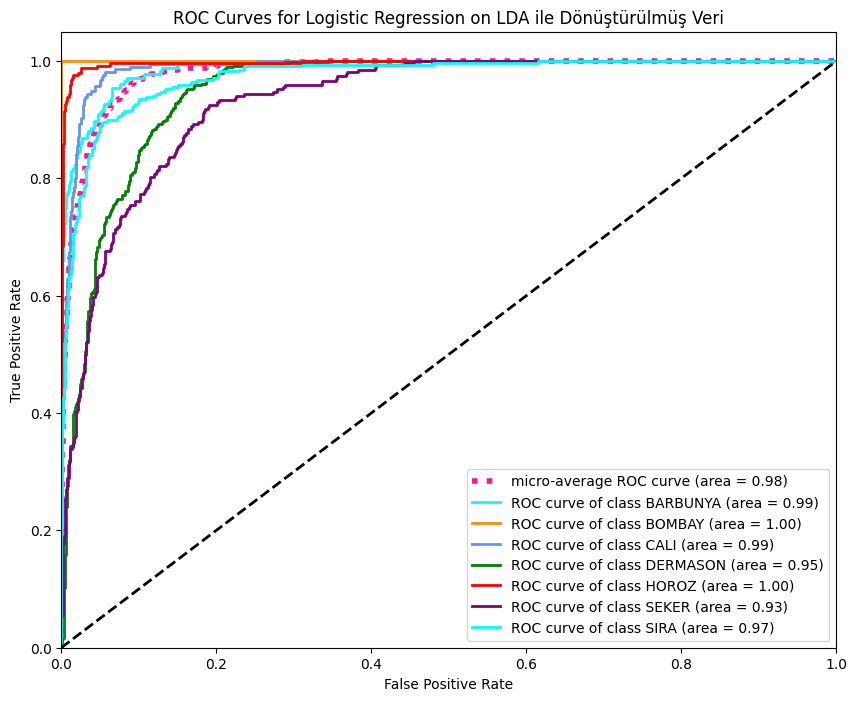

ROC Curve: Veri: LDA ile Dönüştürülmüş Veri, Model: Decision Tree


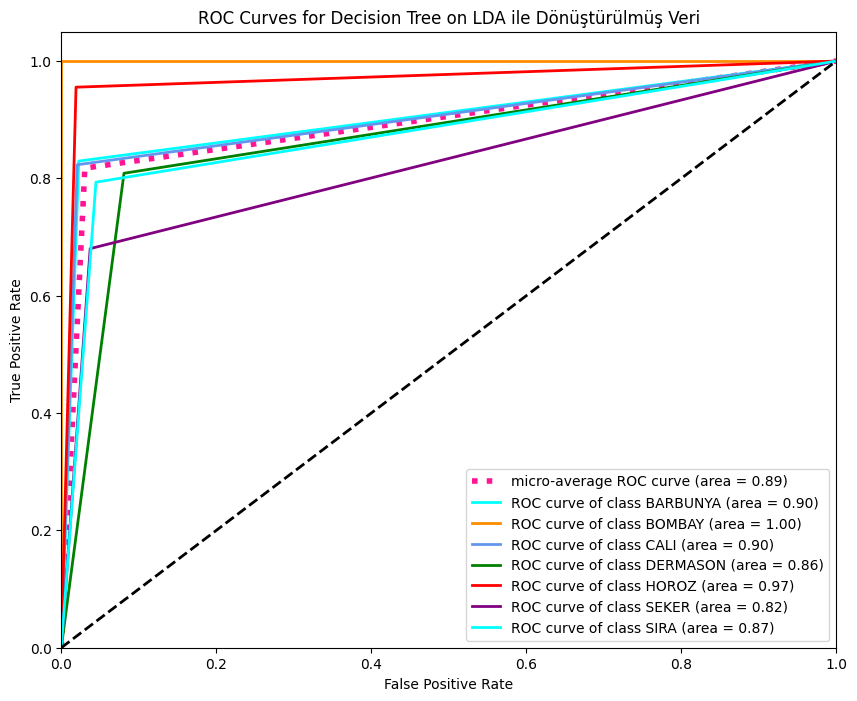

ROC Curve: Veri: LDA ile Dönüştürülmüş Veri, Model: Random Forest


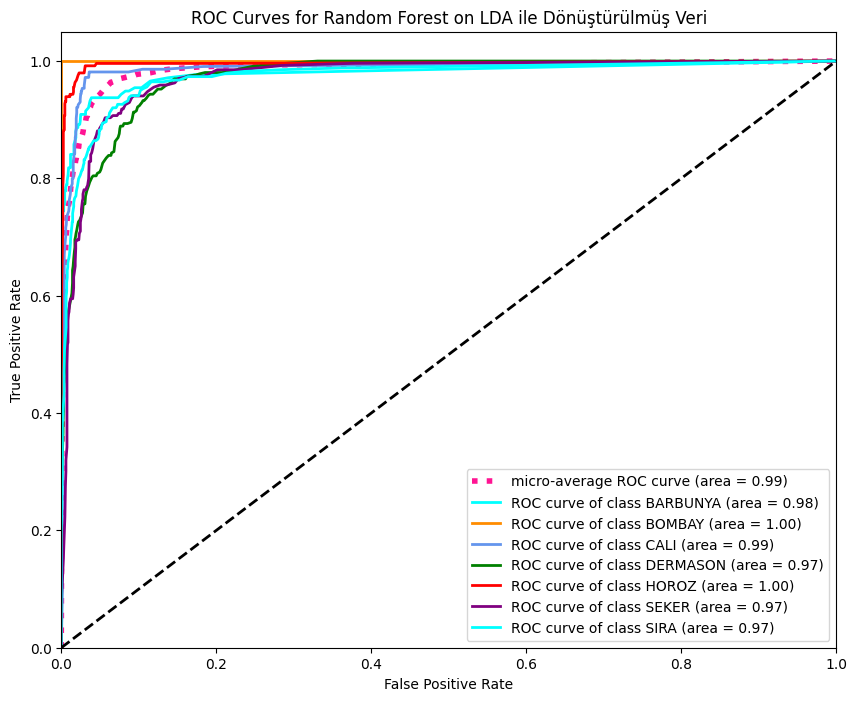

ROC Curve: Veri: LDA ile Dönüştürülmüş Veri, Model: XGBoost


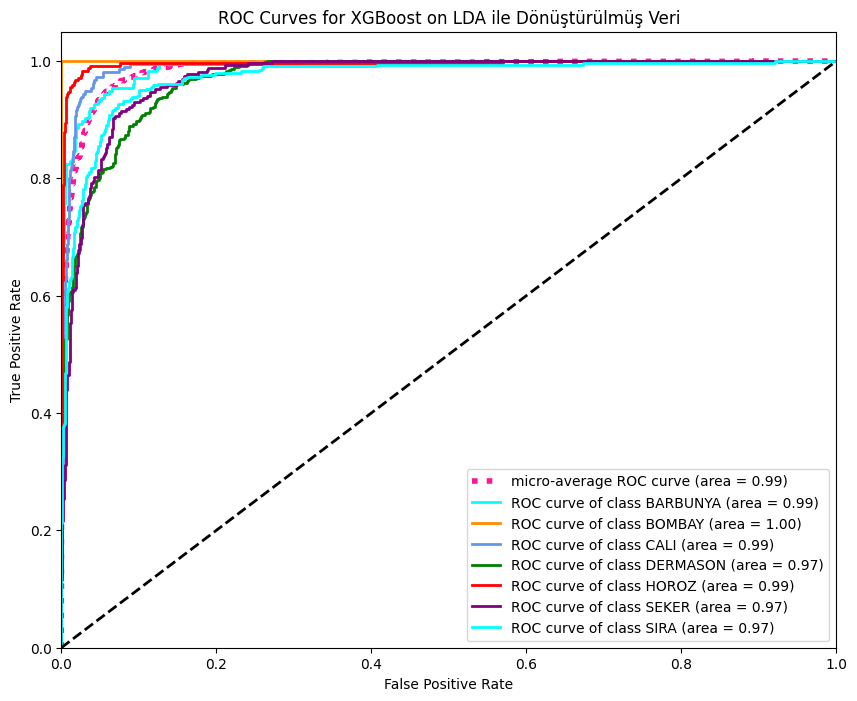

ROC Curve: Veri: LDA ile Dönüştürülmüş Veri, Model: Naive Bayes


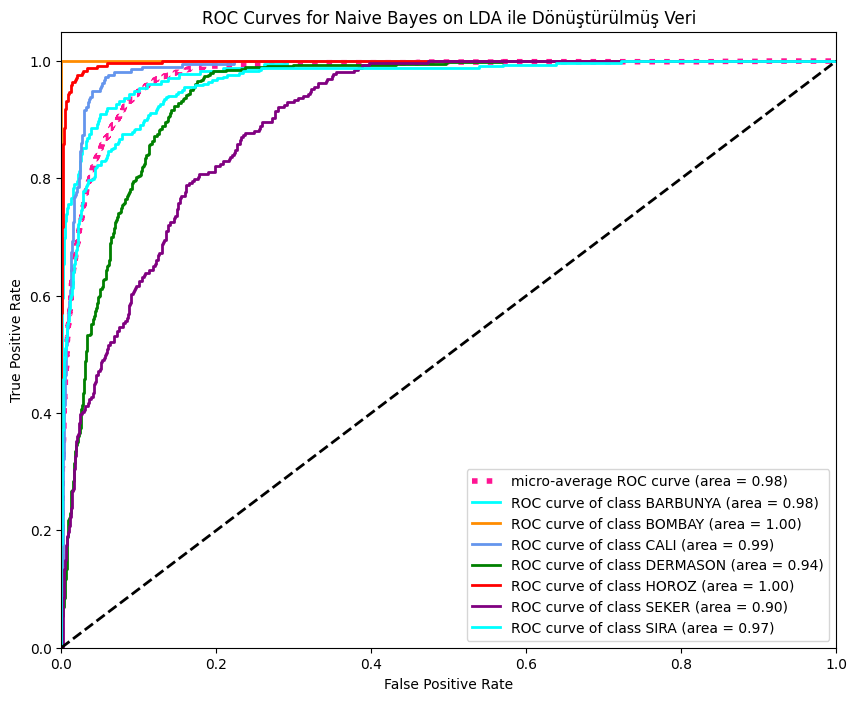

In [21]:
def plot_roc_curves(X, y, model, label_encoder, model_name, data_name):
    """
    ROC eğrilerini çizer ve ROC AUC skorlarını hesaplar.

    Args:
        X: Özellik matrisi.
        y: Hedef değişken.
        model: Sınıflandırma modeli.
        label_encoder: LabelEncoder nesnesi.
        model_name: Modelin adı.
        data_name: Veri setinin adı.
    """
    # Veriyi eğitim ve test kümelerine ayır
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Modeli eğit
    model.fit(X_train, y_train)

    # Sınıfları binarize et
    y_bin = label_binarize(y_test, classes=np.unique(y))
    n_classes = y_bin.shape[1]

    # Tahmin olasılıklarını al
    y_score = model.predict_proba(X_test)

    # ROC eğrilerini ve AUC skorlarını hesapla
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_bin[:, i], y_score[:, i])

    # Mikro ortalama ROC eğrisi ve AUC skoru hesapla
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = roc_auc_score(y_bin.ravel(), y_score.ravel())

    # Tüm ROC eğrilerini çiz
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(label_encoder.inverse_transform([i])[0], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name} on {data_name}')
    plt.legend(loc="lower right")
    plt.show()

# ROC eğrilerini çiz ve AUC skorlarını hesapla
for data_name, (X, y) in data.items():
    for model_name, (model, param_grid) in models.items():
        print(f"ROC Curve: Veri: {data_name}, Model: {model_name}")
        # Modeli yeniden oluştur (eğitim için)
        model_instance = models[model_name][0]
        plot_roc_curves(X, y, model_instance, label_encoder, model_name, data_name)

#### ROC Eğrilerinin Genel Anlamı

ROC (Receiver Operating Characteristic) eğrileri, bir sınıflandırma modelinin farklı eşik değerlerinde nasıl performans gösterdiğini görsel olarak değerlendirmek için kullanılır. Her bir eğri, belirli bir sınıf için modelin
True Positive Rate (TPR - Gerçek Pozitif Oranı) ve False Positive Rate (FPR - Yanlış Pozitif Oranı) arasındaki ilişkiyi gösterir.

- True Positive Rate (TPR): Gerçekte pozitif olan örneklerin ne kadarının model tarafından doğru bir şekilde pozitif olarak tahmin edildiğidir.

- False Positive Rate (FPR): Gerçekte negatif olan örneklerin ne kadarının model tarafından yanlışlıkla pozitif olarak tahmin edildiğidir.

ROC eğrisi ne kadar yukarı ve sola doğru yakınsa, modelin performansı o kadar iyidir. İdeal bir model, sol üst köşeye yakın bir eğriye sahip olacaktır (TPR = 1, FPR = 0).

ROC AUC (Area Under the Curve) skoru, ROC eğrisinin altında kalan alanı temsil eder ve modelin genel sınıflandırma yeteneğini özetler. ROC AUC skoru 1'e ne kadar yakınsa, modelin performansı o kadar iyidir.

Grafiklerin Genel Analizi ve Çıkarımlar:

1. "Logistic Regression on Ham Veri" ve "XGBoost on Ham Veri" Grafikleri: Bu grafiklerdeki ROC eğrileri neredeyse mükemmeldir ve ROC AUC skorları 1.00'e yakındır. Bu, Logistic Regression ve XGBoost modellerinin ham veri ile kullanıldığında, farklı fasulye türlerini mükemmel bir şekilde sınıflandırabildiğini gösterir. Eğrilerin sol üst köşeye çok yakın olması, modelin hem yüksek TPR hem de düşük FPR değerlerine sahip olduğunu gösterir.

2. "Decision Tree on Ham Veri" Grafiği: Bu grafikteki ROC eğrileri de genel olarak iyidir, ancak "Logistic Regression on Ham Veri" ve "XGBoost on Ham Veri" grafiklerine göre biraz daha düşüktür. Bazı sınıflar için ROC AUC skorları 0.91'e kadar düşmektedir. Bu, Decision Tree modelinin ham veri ile kullanıldığında, bazı fasulye türlerini sınıflandırmada diğerlerine göre daha az başarılı olduğunu gösterir.

3. PCA ve LDA ile Dönüştürülmüş Veri Grafikleri: PCA ve LDA ile dönüştürülmüş verilerle elde edilen ROC eğrileri, genellikle ham veri ile elde edilenlere göre daha düşüktür. Bu, boyut indirgeme tekniklerinin veri setindeki önemli bilgileri kaybettiğini ve sınıflandırma performansını olumsuz etkilediğini desteklemektedir.

4. "Naive Bayes" Grafikleri: Naive Bayes modelinin ROC eğrileri, diğer modellere göre daha düşük performans göstermiştir. Bu, Naive Bayes'in özellikler arasındaki bağımsızlık varsayımının bu veri setinde geçerli olmadığını ve modelin sınıflandırma yeteneğini sınırladığını gösterir.

5. "Bombay" Sınıfı: Tüm grafiklerde, "Bombay" sınıfının ROC AUC skoru genellikle 1.00'dir. Bu, "Bombay" fasulye türünün diğer türlerden belirgin şekilde farklı özelliklere sahip olduğunu ve modellerin bu türü kolayca sınıflandırabildiğini gösterir.

Örnek Grafik Yorumları:

- "ROC Curves for Logistic Regression on Ham Veri": "Bu grafik, Logistic Regression modelinin ham veri ile kullanıldığında mükemmel bir sınıflandırma performansına sahip olduğunu göstermektedir. Tüm sınıflar için ROC AUC skorları 1.00'e yakındır, bu da modelin hem yüksek TPR hem de düşük FPR değerlerine sahip olduğunu gösterir. Bu, Logistic Regression modelinin ham veri ile kullanıldığında, kuru fasulye türlerini neredeyse hatasız bir şekilde sınıflandırabildiğini gösterir."

- "ROC Curves for Decision Tree on PCA ile Dönüştürülmüş Veri": "Bu grafik, Decision Tree modelinin PCA ile dönüştürülmüş veri ile kullanıldığında, ham veriye göre daha düşük bir performans sergilediğini göstermektedir. Özellikle "BARBUNYA" ve "CALI" sınıfları için ROC AUC skorları düşüktür (0.76 ve 0.79). Bu, PCA'nın bu türler arasındaki ayrımı zorlaştırdığını ve Decision Tree modelinin bu sınıfları sınıflandırmada daha az başarılı olduğunu gösterir."

Genel Sonuç:

Bu ROC eğrileri, Dry Bean veri setindeki kuru fasulye türlerini sınıflandırmak için en etkili yaklaşımın, ham veri ile Logistic Regression veya XGBoost modellerini kullanmak olduğunu doğrulamaktadır. Boyut indirgeme teknikleri ve Naive Bayes modeli, bu veri setinde daha düşük performans göstermiştir. Ayrıca, bazı fasulye türlerinin (örneğin, "Bombay") diğerlerinden daha kolay sınıflandırıldığı da görülmektedir.